<a href="https://colab.research.google.com/github/Heyy-Soumya/Skin-Lesion-Classification-using-Deep-Learning/blob/main/SkinDisease_phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files

print("✅ Libraries imported. Now setting up Kaggle API...")

# Upload kaggle.json
files.upload()

# Configure API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle API configured successfully!")


✅ Libraries imported. Now setting up Kaggle API...


Saving kaggle.json to kaggle (1).json

✅ Kaggle API configured successfully!


In [ ]:

# Download the balanced dataset
!kaggle datasets download -d riyaelizashaju/skin-disease-image-dataset-balanced

# Unzip quietly
!unzip -q skin-disease-image-dataset-balanced.zip

print("✅ Dataset downloaded and unzipped!")

# CRITICAL STEP: Check the folder name so we don't get FileNotFoundError
print("\n👇 Here are the folders we just downloaded:")
!ls

Dataset URL: https://www.kaggle.com/datasets/riyaelizashaju/skin-disease-image-dataset-balanced
License(s): CC-BY-NC-SA-4.0
skin-disease-image-dataset-balanced.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Split_smol/train/Actinic keratosis/ISIC_0024468.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset downloaded and unzipped!

👇 Here are the folders we just downloaded:
'Dermoscopic actinic keratosis (1).jpg'
'Dermoscopic actinic keratosis.jpg'
'Dermoscopic Basal Cell Carcinoma.jpg'
'Dermoscopic melanoma (1).jpg'
'Dermoscopic melanoma.jpg'
'kaggle (1).json'
 kaggle.json
 sample_data
 skin-disease-image-dataset-balanced.zip
 Split_smol


In [ ]:
# --- CORRECTED STEP 3: Data Generators (No Rescaling) ---

# Pointing to the folders inside 'Split_smol'
TRAIN_DIR = 'Split_smol/train'
VAL_DIR = 'Split_smol/val'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# 1. Training Generator (Removed rescale=1./255)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Validation Generator (Removed rescale=1./255)
val_datagen = ImageDataGenerator()

# 3. Load the Images
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\nLoading Validation Data:")
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Loading Training Data:
Found 1849 images belonging to 8 classes.

Loading Validation Data:
Found 459 images belonging to 8 classes.


In [ ]:
# --- 1. Load the Pre-Trained Expert Model ---
base_model = EfficientNetV2B0(
    weights='imagenet',       # Use knowledge from standard dataset
    include_top=False,        # Drop the original classification layer (we will add our own)
    input_shape=(224, 224, 3) # Match our image size
)

# Freeze the base model (don't train it yet)
base_model.trainable = False

# --- 2. Add Custom Classification Layers ---
x = base_model.output
x = GlobalAveragePooling2D()(x) # Compress the features
x = Dropout(0.2)(x)             # Prevent overfitting (randomly drop 20% of connections)

# Final Output Layer: 8 neurons for 8 disease classes
predictions = Dense(8, activation='softmax')(x)

# --- 3. Assemble and Compile ---
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001), # Standard starting speed
    loss='categorical_crossentropy',     # Metric for multi-class problems
    metrics=['accuracy']
)

print("✅ Model built successfully!")
model.summary()

✅ Model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,929,560 (22.62 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
print("--- Starting Stage 1 Training (Training the Head) ---")

# Train for 12 epochs
history_stage1 = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator
)

print("\n✅ Stage 1 complete!")

--- Starting Stage 1 Training (Training the Head) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.2171 - loss: 2.0133 - val_accuracy: 0.3747 - val_loss: 1.7193
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 616ms/step - accuracy: 0.4483 - loss: 1.5150 - val_accuracy: 0.4248 - val_loss: 1.5678
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 615ms/step - accuracy: 0.4935 - loss: 1.4115 - val_accuracy: 0.4466 - val_loss: 1.4855
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 602ms/step - accuracy: 0.5589 - loss: 1.2454 - val_accuracy: 0.4924 - val_loss: 1.4159
Epoch 5/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 603ms/step - accuracy: 0.5577 - loss: 1.2067 - val_accuracy: 0.5054 - val_loss: 1.3683
Epoch 6/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 609ms/step - accuracy: 0.5857 - loss: 1.1737 - val_accuracy: 0.5054 - val_loss: 1.3480
Epoch 7/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 614ms/step - accuracy: 0.5933 - loss: 1.1249 - val_accuracy: 0.5316 - val_loss: 1.3179
Epoch 8/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 613ms/step - accuracy: 0.5960 - loss: 1.1275 - val_accurac

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# --- STAGE 2: FINE-TUNING WITH EARLY STOPPING ---
print("--- Starting Stage 2 Training (Fine-Tuning) ---")

base_model.trainable = True

# Freeze bottom 50 layers
for layer in base_model.layers[:50]:
    layer.trainable = False

# Re-compile with LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define Early Stopping
# Stop if validation accuracy doesn't improve for 5 epochs
stopper = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train with the callback
history_stage2 = model.fit(
    train_generator,
    epochs=32,
    initial_epoch=12,
    validation_data=val_generator,
    callbacks=[stopper] # <--- Added this!
)

print("\n✅ Stage 2 complete!")

--- Starting Stage 2 Training (Fine-Tuning) ---
Epoch 13/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4318 - loss: 1.5032 - val_accuracy: 0.5490 - val_loss: 1.1786
Epoch 14/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 634ms/step - accuracy: 0.6848 - loss: 0.9706 - val_accuracy: 0.6013 - val_loss: 1.0014
Epoch 15/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 635ms/step - accuracy: 0.7291 - loss: 0.7734 - val_accuracy: 0.6296 - val_loss: 0.9378
Epoch 16/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 635ms/step - accuracy: 0.7658 - loss: 0.6594 - val_accuracy: 0.6580 - val_loss: 0.8811
Epoch 17/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 640ms/step - accuracy: 0.8278 - loss: 0.5272 - val_accuracy: 0.6819 - val_loss: 0.8641
Epoch 18/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 636ms/step - accuracy: 0.8456 - loss: 0.4389 - val_accuracy: 0.6906 - val_loss: 0.8596
Epoch 19/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 639ms/step - accuracy: 0.8841 - loss: 0.3657 - val_accuracy: 0.7190 - val_loss: 0.8127
Epoch 20/32
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 6

In [ ]:
# Save the model to a file
model.save('isic_multi_class_model.keras')
print("✅ Model saved successfully!")

# Optional: Download it to your computer (just in case)
from google.colab import files
files.download('isic_multi_class_model.keras')

Generating predictions on Validation Data...
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 622ms/step


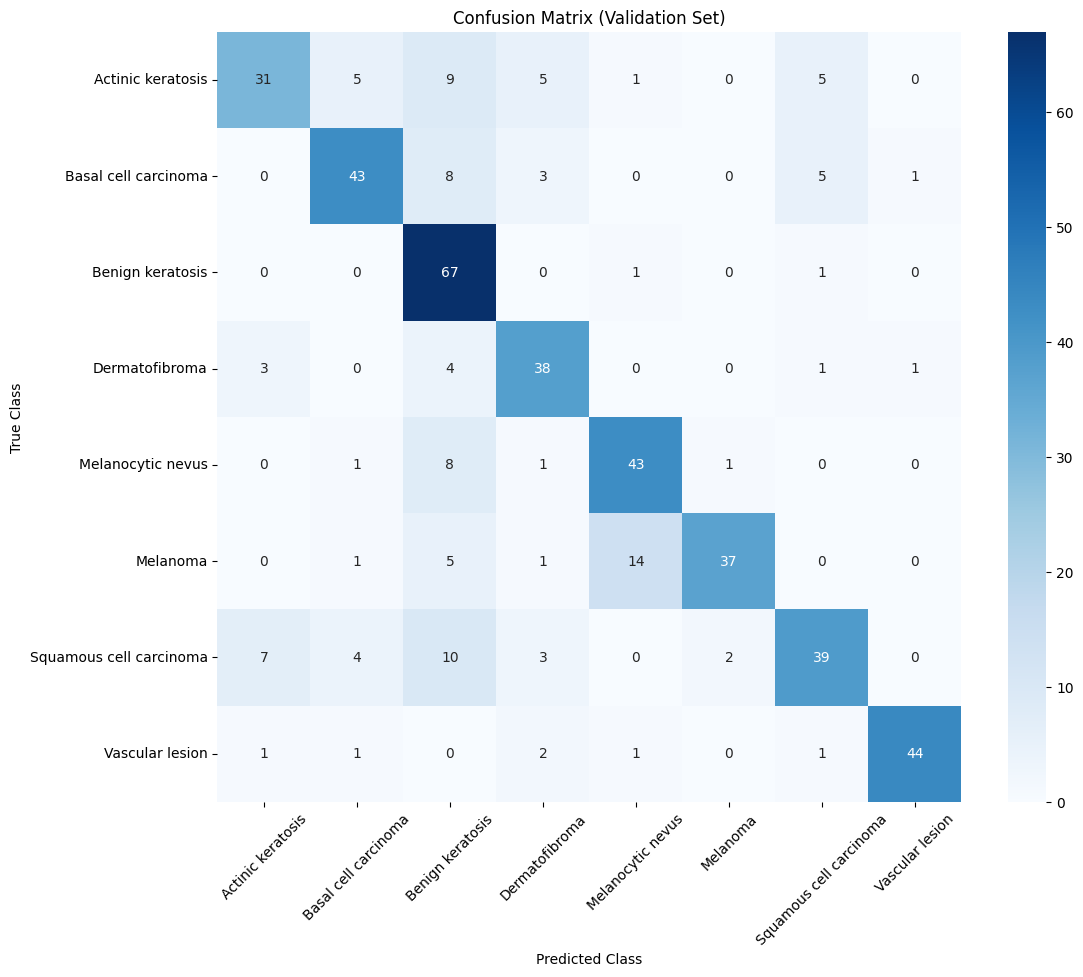


Classification Report:

                         precision    recall  f1-score   support

      Actinic keratosis       0.74      0.55      0.63        56
   Basal cell carcinoma       0.78      0.72      0.75        60
       Benign keratosis       0.60      0.97      0.74        69
         Dermatofibroma       0.72      0.81      0.76        47
      Melanocytic nevus       0.72      0.80      0.75        54
               Melanoma       0.93      0.64      0.76        58
Squamous cell carcinoma       0.75      0.60      0.67        65
        Vascular lesion       0.96      0.88      0.92        50

               accuracy                           0.75       459
              macro avg       0.77      0.75      0.75       459
           weighted avg       0.77      0.75      0.74       459



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Reset the validation generator to the start
val_generator.reset()

# 2. Get predictions
print("Generating predictions on Validation Data...")
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 4. Create the Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 5. Plot the Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45)
plt.show()

# 6. Print the Detailed Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Please upload a dermoscopic image of a skin lesion:


Saving Dermoscopic melanoma.jpg to Dermoscopic melanoma (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


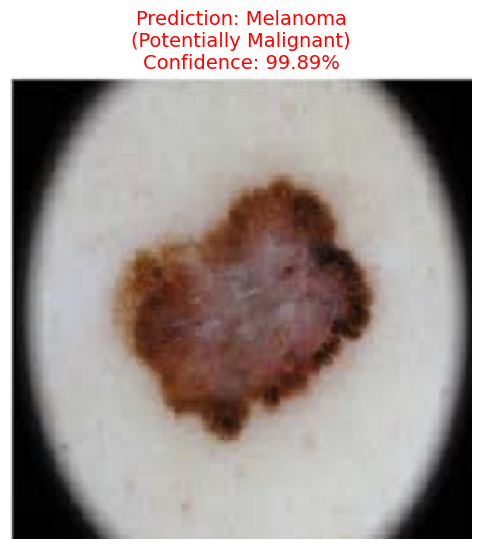


Detailed Probabilities:
Actinic keratosis: 0.00%
Basal cell carcinoma: 0.00%
Benign keratosis: 0.00%
Dermatofibroma: 0.00%
Melanocytic nevus: 0.10%
Melanoma: 99.89%
Squamous cell carcinoma: 0.00%
Vascular lesion: 0.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

# --- 1. UPLOAD IMAGE ---
print("Please upload a dermoscopic image of a skin lesion:")
uploaded = files.upload()

# --- 2. PREDICT ---
# We loop through files in case you uploaded more than one
for filename in uploaded.keys():
    img_path = filename

    # Load the image with the same size as training (224x224)
    # Note: We do NOT rescale by 1/255 here because we removed it from the generator earlier!
    # If the model expects 0-255, we pass raw image data.
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Add a "batch" dimension (the model expects a list of images, even if it's just one)
    img_batch = np.expand_dims(img_array, axis=0)

    # Make the prediction
    predictions = model.predict(img_batch)

    # Get the highest probability
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    # Get the class name using the generator's labels
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[predicted_index]

    # --- 3. DISPLAY RESULT ---
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    # Color code the title: Red for Malignant, Green for Benign
    # (Checking if 'Melanoma' or 'Carcinoma' is in the name)
    if 'Melanoma' in predicted_class or 'Carcinoma' in predicted_class:
        color = 'red'
        status = "(Potentially Malignant)"
    else:
        color = 'green'
        status = "(Likely Benign)"

    plt.title(f"Prediction: {predicted_class}\n{status}\nConfidence: {confidence:.2f}%", color=color, fontsize=14)
    plt.show()

    # Print raw probabilities for detailed analysis
    print("\nDetailed Probabilities:")
    for i, label in enumerate(class_labels):
        print(f"{label}: {predictions[0][i]*100:.2f}%")

Please upload a dermoscopic image of a skin lesion:


Saving Dermoscopic actinic keratosis.jpg to Dermoscopic actinic keratosis (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


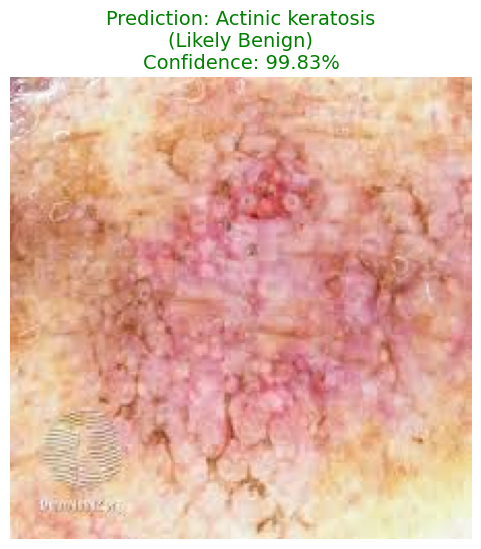


Detailed Probabilities:
Actinic keratosis: 99.83%
Basal cell carcinoma: 0.07%
Benign keratosis: 0.01%
Dermatofibroma: 0.01%
Melanocytic nevus: 0.01%
Melanoma: 0.02%
Squamous cell carcinoma: 0.04%
Vascular lesion: 0.01%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

# --- 1. UPLOAD IMAGE ---
print("Please upload a dermoscopic image of a skin lesion:")
uploaded = files.upload()

# --- 2. PREDICT ---
# We loop through files in case you uploaded more than one
for filename in uploaded.keys():
    img_path = filename

    # Load the image with the same size as training (224x224)
    # Note: We do NOT rescale by 1/255 here because we removed it from the generator earlier!
    # If the model expects 0-255, we pass raw image data.
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Add a "batch" dimension (the model expects a list of images, even if it's just one)
    img_batch = np.expand_dims(img_array, axis=0)

    # Make the prediction
    predictions = model.predict(img_batch)

    # Get the highest probability
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    # Get the class name using the generator's labels
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[predicted_index]

    # --- 3. DISPLAY RESULT ---
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    # Color code the title: Red for Malignant, Green for Benign
    # (Checking if 'Melanoma' or 'Carcinoma' is in the name)
    if 'Melanoma' in predicted_class or 'Carcinoma' in predicted_class:
        color = 'red'
        status = "(Potentially Malignant)"
    else:
        color = 'green'
        status = "(Likely Benign)"

    plt.title(f"Prediction: {predicted_class}\n{status}\nConfidence: {confidence:.2f}%", color=color, fontsize=14)
    plt.show()

    # Print raw probabilities for detailed analysis
    print("\nDetailed Probabilities:")
    for i, label in enumerate(class_labels):
        print(f"{label}: {predictions[0][i]*100:.2f}%")